# PlanetScope waterline extraction

This takes mosaiced PlanetScope layers (generated using `mosaic_planet.ipynb`) and uses Dask to import them as an xarray dataset and extract waterline contours.

In [1]:
import os
import sys
import glob
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import affine
import gdal
import fiona
import collections
import numpy as np
from skimage.measure import find_contours
from shapely.geometry import MultiLineString, mapping

import sys
sys.path.append('../10_Scripts')
import DEAPlotting, SpatialTools, DEADataHandling

def contour_extract(z_values, ds_array, ds_crs, ds_affine, output_shp=None, min_vertices=2,
                    attribute_data=None, attribute_dtypes=None):

    """
    Uses `skimage.measure.find_contours` to extract contour lines from a two-dimensional array.
    Contours are extracted as a dictionary of xy point arrays for each contour z-value, and optionally as
    line shapefile with one feature per contour z-value.

    The `attribute_data` and `attribute_dtypes` parameters can be used to pass custom attributes to the output
    shapefile.

    Last modified: September 2018
    Author: Robbi Bishop-Taylor

    :param z_values:
        A list of numeric contour values to extract from the array.

    :param ds_array:
        A two-dimensional array from which contours are extracted. This can be a numpy array or xarray DataArray.
        If an xarray DataArray is used, ensure that the array has one two dimensions (e.g. remove the time dimension
        using either `.isel(time=0)` or `.squeeze('time')`).

    :param ds_crs:
        Either a EPSG string giving the coordinate system of the array (e.g. 'EPSG:3577'), or a crs
        object (e.g. from an xarray dataset: `xarray_ds.geobox.crs`).

    :param ds_affine:
        Either an affine object from a rasterio or xarray object (e.g. `xarray_ds.geobox.affine`), or a gdal-derived
        geotransform object (e.g. `gdal_ds.GetGeoTransform()`) which will be converted to an affine.

    :param min_vertices:
        An optional integer giving the minimum number of vertices required for a contour to be extracted. The default
        (and minimum) value is 2, which is the smallest number required to produce a contour line (i.e. a start and
        end point). Higher values remove smaller contours, potentially removing noise from the output dataset.

    :param output_shp:
        An optional string giving a path and filename for the output shapefile. Defaults to None, which
        does not generate a shapefile.

    :param attribute_data:
        An optional dictionary of lists used to define attributes/fields to add to the shapefile. Dict keys give
        the name of the shapefile attribute field, while dict values must be lists of the same length as `z_values`.
        For example, if `z_values=[0, 10, 20]`, then `attribute_data={'type: [1, 2, 3]}` can be used to create a
        shapefile field called 'type' with a value for each contour in the shapefile. The default is None, which
        produces a default shapefile field called 'z_value' with values taken directly from the `z_values` parameter
        and formatted as a 'float:9.2'.

    :param attribute_dtypes:
        An optional dictionary giving the output dtype for each shapefile attribute field that is specified by
        `attribute_data`. For example, `attribute_dtypes={'type: 'int'}` can be used to set the 'type' field to an
        integer dtype. The dictionary should have the same keys/field names as declared in `attribute_data`.
        Valid values include 'int', 'str', 'datetime, and 'float:X.Y', where X is the minimum number of characters
        before the decimal place, and Y is the number of characters after the decimal place.

    :return:
        A dictionary with contour z-values as the dict key, and a list of xy point arrays as dict values.

    :example:

    >>> # Import modules
    >>> import sys
    >>> import datacube

    >>> # Import external dea-notebooks functions using relative link to Scripts directory
    >>> sys.path.append('../10_Scripts')
    >>> import SpatialTools

    >>> # Set up datacube instance
    >>> dc = datacube.Datacube(app='Contour extraction')

    >>> # Define an elevation query
    >>> elevation_query = {'lat': (-35.25, -35.35),
    ...                    'lon': (149.05, 149.17),
    ...                    'output_crs': 'EPSG:3577',
    ...                    'resolution': (-25, 25)}

    >>> # Import sample elevation data
    >>> elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)

    >>> # Remove the time dimension so that array is two-dimensional
    >>> elevation_2d = elevation_data.dem_h.squeeze('time')

    >>> # Extract contours
    >>> contour_dict = SpatialTools.contour_extract(z_values=[600, 700, 800],
    ...                                             ds_array=elevation_2d,
    ...                                             ds_crs=elevation_2d.geobox.crs,
    ...                                             ds_affine=elevation_2d.geobox.affine,
    ...                                             output_shp='extracted_contours.shp')
    Extracting contour 600
    Extracting contour 700
    Extracting contour 800
    <BLANKLINE>
    Exporting contour shapefile to extracted_contours.shp

    """

    # First test that input array has only two dimensions:
    if len(ds_array.shape) == 2:

        # Obtain affine object from either rasterio/xarray affine or a gdal geotransform:
        if type(ds_affine) != affine.Affine:

            ds_affine = affine.Affine.from_gdal(*ds_affine)

        ####################
        # Extract contours #
        ####################

        # Output dict to hold contours for each offset
        contours_dict = collections.OrderedDict()

        for z_value in z_values:

            # Extract contours and convert output array pixel coordinates into arrays of real world Albers coordinates.
            # We need to add (0.5 x the pixel size) to x values and subtract (-0.5 * pixel size) from y values to
            # correct coordinates to give the centre point of pixels, rather than the top-left corner
            print(f'Extracting contour {z_value}')
            ps = ds_affine[0]  # Compute pixel size
            contours_geo = [np.column_stack(ds_affine * (i[:, 1], i[:, 0])) + np.array([0.5 * ps, -0.5 * ps]) for i in
                            find_contours(ds_array, z_value)]

            # For each array of coordinates, drop any xy points that have NA
            contours_nona = [i[~np.isnan(i).any(axis=1)] for i in contours_geo]

            # Drop 0 length and add list of contour arrays to dict
            contours_withdata = [i for i in contours_nona if len(i) >= min_vertices]

            # If there is data for the contour, add to dict:
            if len(contours_withdata) > 0:
                contours_dict[z_value] = contours_withdata
            else:
                print(f'    No data for contour {z_value}; skipping')

        #######################
        # Export to shapefile #
        #######################

        # If a shapefile path is given, generate shapefile
        if output_shp:

            print(f'\nExporting contour shapefile to {output_shp}')

            # If attribute fields are left empty, default to including a single z-value field based on `z_values`
            if not attribute_data:

                # Default field uses two decimal points by default
                attribute_data = {'z_value': z_values}
                attribute_dtypes = {'z_value': 'float:9.2'}

            # Set up output multiline shapefile properties
            schema = {'geometry': 'MultiLineString',
                      'properties': attribute_dtypes}
            
            # Create output shapefile for writing
            with fiona.open(output_shp, 'w',
                            crs={'init': str(ds_crs), 'no_defs': True},
                            driver='ESRI Shapefile',
                            schema=schema) as output:

                # Write each shapefile to the dataset one by one
                for i, (z_value, contours) in enumerate(contours_dict.items()):

                    # Create multi-string object from all contour coordinates
                    contour_multilinestring = MultiLineString(contours)

                    # Get attribute values for writing
                    attribute_vals = {field_name: field_vals[i] for field_name, field_vals in attribute_data.items()}

                    # Write output shapefile to file with z-value field
                    output.write({'properties': attribute_vals,
                                  'geometry': mapping(contour_multilinestring)})

        # Return dict of contour arrays
        return contours_dict

    else:
        print(f'The input `ds_array` has shape {ds_array.shape}. Please input a two-dimensional array (if your '
              f'input array has a time dimension, remove it using `.isel(time=0)` or `.squeeze(\'time\')`)')

        
def time_index_from_filenames(filenames, string_slice=slice(0, 10)):
    '''
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string
    '''
    
    date_strings = [os.path.basename(i)[string_slice] for i in filenames]
    
    return pd.to_datetime(date_strings)


# Set working directory
os.chdir('/g/data/r78/planetlabs')



## Load PlanetScope daily mosaic rasters into an xarray dataset
This uses dask, so the data isn't loaded into memory yet to reduce processing time

In [2]:
# Get file paths and obtain list of dates from file
mosaic_list = sorted(glob.glob('data/planetscope/mosaics/*_planetscope.tif'))

# Import data and create xarray dask array labelled by timestamps from files
time_var = xr.Variable('time', time_index_from_filenames(mosaic_list, string_slice=slice(0, 8)))
chunks = {'x': 1452, 'y': 1839, 'band': 1}
concat_arrays = xr.concat([xr.open_rasterio(i, chunks=chunks) for i in mosaic_list], dim=time_var)

# Convert to dataset and set band names
concat_ds = concat_arrays.to_dataset(dim='band')
concat_ds = concat_ds.rename({1: 'blue', 2: 'green', 3: 'red', 4: 'nir'})
concat_ds = concat_ds.sortby('time')
concat_ds


<xarray.Dataset>
Dimensions:  (time: 227, x: 1452, y: 1839)
Coordinates:
  * y        (y) float64 6.741e+06 6.741e+06 6.741e+06 ... 6.735e+06 6.735e+06
  * x        (x) float64 2.128e+05 2.128e+05 2.128e+05 ... 2.172e+05 2.172e+05
  * time     (time) datetime64[ns] 2017-03-11 2017-03-20 ... 2018-06-26
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(227, 1839, 1452), chunksize=(1, 1839, 1452)>
    green    (time, y, x) uint16 dask.array<shape=(227, 1839, 1452), chunksize=(1, 1839, 1452)>
    red      (time, y, x) uint16 dask.array<shape=(227, 1839, 1452), chunksize=(1, 1839, 1452)>
    nir      (time, y, x) uint16 dask.array<shape=(227, 1839, 1452), chunksize=(1, 1839, 1452)>
Attributes:
    transform:   (3.0, 0.0, 212838.0, 0.0, -3.0, 6740733.0)
    crs:         +init=epsg:32756
    res:         (3.0, 3.0)
    is_tiled:    0
    nodatavals:  (0.0, 0.0, 0.0, 0.0)

## Import data using Dask's compute
PlanetScope data is very large and memory intensive. For a quick example, here we use Dask to load only a limited area and time period from the full dataset into memory:

In [40]:
# Specify subset of study area to load
time_slice = slice('2017-03-01', '2018-02-28')
x_slice = slice(214700, 215420)
y_slice = slice(6740400, 6739600)

# Compute the percentage of pixels with valid data per timestep and set nodata
subset_ds = concat_ds.sel(time=time_slice, x=x_slice, y=y_slice)
# perc_baddata = (subset_ds == 0.0).sum(dim=['x', 'y']) / (subset_ds.sizes['x'] * subset_ds.sizes['y'])
subset_ds = subset_ds.where(subset_ds != 0)

# Load into memory
subset_ds = subset_ds.compute()
subset_ds


<xarray.Dataset>
Dimensions:  (time: 140, x: 240, y: 267)
Coordinates:
  * y        (y) float64 6.74e+06 6.74e+06 6.74e+06 ... 6.74e+06 6.74e+06
  * x        (x) float64 2.147e+05 2.147e+05 2.147e+05 ... 2.154e+05 2.154e+05
  * time     (time) datetime64[ns] 2017-03-11 2017-03-20 ... 2018-02-28
Data variables:
    blue     (time, y, x) float64 nan nan nan nan ... 960.0 1.01e+03 1e+03 965.0
    green    (time, y, x) float64 nan nan nan ... 1.114e+03 1.097e+03 1.067e+03
    red      (time, y, x) float64 nan nan nan ... 1.291e+03 1.29e+03 1.26e+03
    nir      (time, y, x) float64 nan nan nan ... 1.659e+03 1.662e+03 1.661e+03
Attributes:
    transform:   (3.0, 0.0, 212838.0, 0.0, -3.0, 6740733.0)
    crs:         +init=epsg:32756
    res:         (3.0, 3.0)
    is_tiled:    0
    nodatavals:  (0.0, 0.0, 0.0, 0.0)

### Compute NDWI

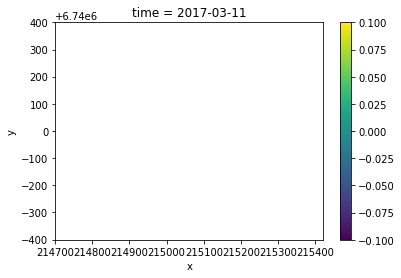

In [43]:
# Compute index and plot
ndwi = (subset_ds.green - subset_ds.nir) / (subset_ds.green + subset_ds.nir)
ndwi.isel(time=0).plot()


## Extract waterlines
Here we use the extract contours function to return the approximate waterline for each PlanetScope daily mosaic. Contours are exported as a shapefile per mosaic, and a single combined dataset. Each contour is also given an attribute indicating the area of inundated pixels for that timestep:

In [ ]:
# Create custom affine based on subset. Make sure to adjust top-left pixel coordinates by half a pixel to get top-left corner
cust_affine = affine.Affine(3.0, 0, ndwi.x.min().values.item() - 1.5, 0, -3.0, ndwi.y.max().values.item() + 1.5)

# For each timestep
for n in ndwi.time:
    
    # Get date string for timestep
    date_string = n.values.astype('str')[0:10]
    
    # Compute area of wet pixels to assign to each contour
    area = ((ndwi.sel(time=date_string) > -0.1).sum().values.item() * (3.0 * 3.0))  
    
    # Prepare attributes as input to contour extract
    attribute_data = {'area_m': [area],
                      'date': [date_string]}
    attribute_dtypes = {'area_m': 'int',
                        'date': 'str'}

    # Extract contours with custom attribute fields:
    contour_dict = contour_extract(z_values=[-0.1],
                                   ds_array=ndwi.sel(time=date_string),
                                   ds_crs='epsg:32756',
                                   ds_affine=cust_affine,
                                   output_shp=f'extracted_contour_{date_string}.shp',
                                   attribute_data=attribute_data,
                                   attribute_dtypes=attribute_dtypes)

# Combine all shapefiles into one file
shapefiles = glob.glob("extracted_contour_*.shp")
gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles], sort=False).pipe(gpd.GeoDataFrame)

# Fix columns and save as shapefile
gdf['area_m'] = gdf.area_m.astype('int')
gdf = gdf.reset_index()[['area_m', 'date', 'geometry']].sort_values('area_m')
gdf.crs = 'epsg:32756'
gdf.to_file('all_contours.shp')

# Show head
gdf.head()


In [70]:
ndwi2 = ndwi.resample(time='1W').median(dim='time') #.plot(col='time', col_wrap=4)
ndwi2['obs'] = ndwi.resample(time='1W').count(dim='time').max(dim=['x', 'y']) 
ndwi2 = ndwi2.sel(time = ndwi2.obs > 2)

# Create custom affine based on subset. Make sure to adjust top-left pixel coordinates by half a pixel to get top-left corner
cust_affine = affine.Affine(3.0, 0, ndwi2.x.min().values.item() - 1.5, 0, -3.0, ndwi2.y.max().values.item() + 1.5)

custom_attrs = {'area_m': ((ndwi2 > -0.15).sum(dim=['x','y']) * (3.0 * 3.0)).values.tolist(),
                'date': [str(i)[0:10] for i in ndwi2.time.values]}
custom_attrs_dtypes = {'area_m': 'float', 'date': 'str'}

# Extract contours with custom attribute fields:
contour_gdf = SpatialTools.contour_extract(z_values=[-0.15],
                                           ds_array=ndwi2,
                                           ds_crs='epsg:32756',
                                           ds_affine=cust_affine,
                                           output_shp='all_contours2.shp',
                                           attribute_data=custom_attrs,
                                           attribute_dtypes=custom_attrs_dtypes,
                                           min_vertices=10,
#                                            dim='level_m',
                                           verbose=False)

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to all_contours2.shp


<xarray.DataArray (time: 21, y: 267, x: 240)>
array([[[-0.336637, -0.363552, ..., -0.357727, -0.352865],
        [-0.347452, -0.377586, ..., -0.3634  , -0.354644],
        ...,
        [-0.486244, -0.478802, ..., -0.291987, -0.289617],
        [-0.479369, -0.460567, ..., -0.303401, -0.305581]],

       [[-0.362687, -0.366152, ..., -0.32342 , -0.323892],
        [-0.35335 , -0.347939, ..., -0.328916, -0.32932 ],
        ...,
        [-0.383459, -0.384805, ..., -0.287671, -0.268487],
        [-0.378882, -0.385933, ..., -0.283565, -0.266821]],

       ...,

       [[-0.311879, -0.309342, ..., -0.801168, -0.801406],
        [-0.309784, -0.306374, ..., -0.797543, -0.799827],
        ...,
        [-0.74841 , -0.749225, ..., -0.279324, -0.273688],
        [-0.748149, -0.748644, ..., -0.280485, -0.280543]],

       [[-0.269634, -0.268647, ..., -0.746011, -0.744055],
        [-0.260165, -0.261408, ..., -0.745303, -0.745937],
        ...,
        [-0.691273, -0.704383, ..., -0.254169, -0.255894]

In [64]:
ndwi2.obs

<xarray.DataArray 'obs' (time: 52)>
array([ 0., nan,  2., nan,  1., nan,  3.,  2.,  0., nan,  3.,  2., nan,  1.,
        3.,  1.,  1.,  4.,  3.,  2., nan,  1.,  1.,  4.,  4.,  4.,  2., nan,
       nan,  2.,  2., nan, nan,  1.,  5.,  5.,  2.,  4.,  2.,  4.,  6.,  5.,
        4.,  3.,  4.,  2.,  6.,  4.,  4.,  5.,  2.,  2.])
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12 2017-03-19 ... 2018-03-04
    obs      (time) float64 0.0 nan 2.0 nan 1.0 nan ... 6.0 4.0 4.0 5.0 2.0 2.0

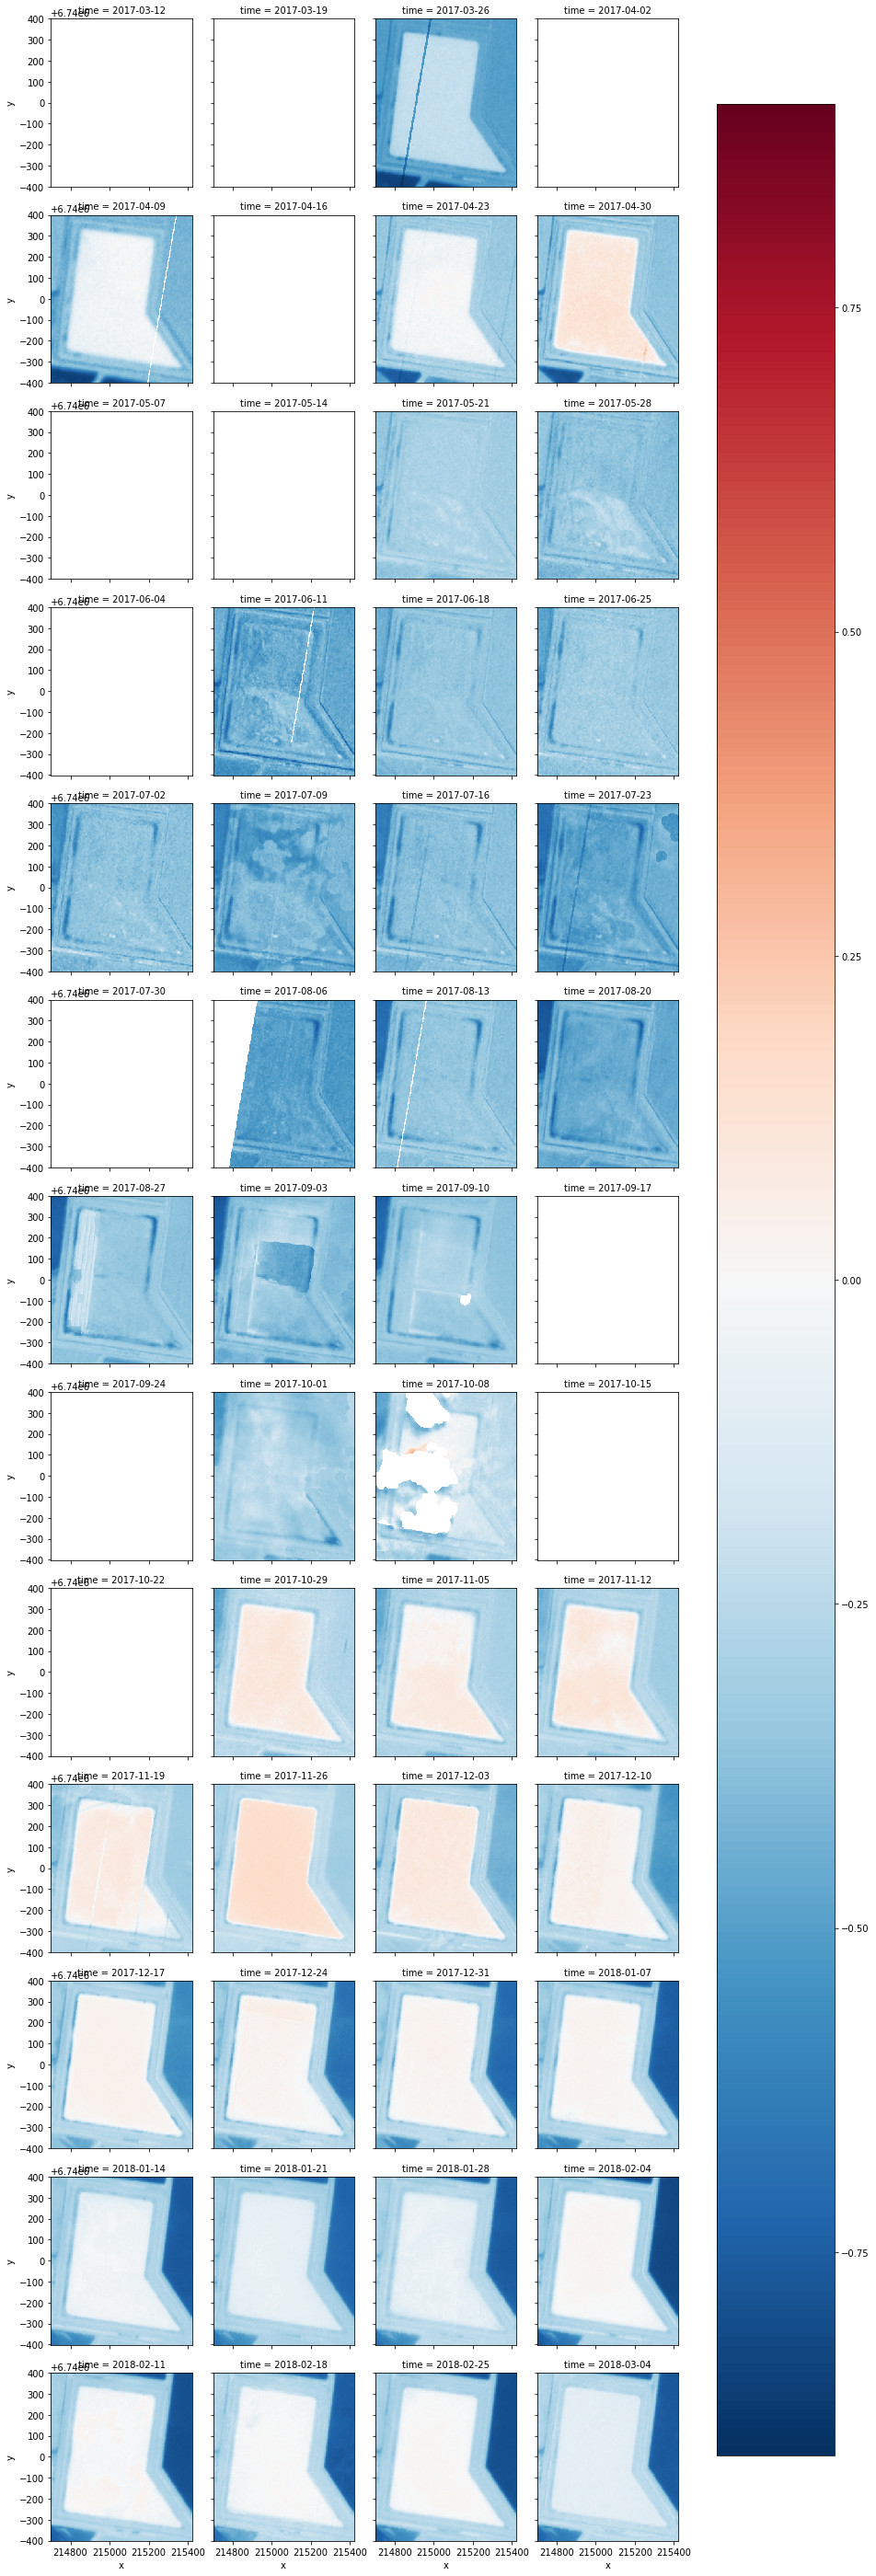

In [45]:
ndwi2.plot(col='time', col_wrap=4)

## Plot and save contour maps

In [ ]:
# Plot entire dam
fig, ax = plt.subplots(figsize=(12, 12))
subset_ds[['red', 'green', 'blue']].isel(time=29).to_array().plot.imshow(ax=ax, vmin=0, vmax=4000)

# Filter to wet timesteps (arbitrary)
gdf[gdf.area_m > 225000].plot(ax=ax, column = 'area_m', cmap='Blues', scheme='quantiles', lw=0.8, 
         legend=True, legend_kwds={'title': 'Water area (m^2)'})
# plt.savefig('all_contours.png', dpi=300, bbox_inches='tight')

In [ ]:
# Plot zoomed subset
fig, ax = plt.subplots(figsize=(12, 12))
subset_ds[['red', 'green', 'blue']].isel(time=29).to_array().plot.imshow(ax=ax, vmin=0, vmax=4000)
gdf[gdf.area_m > 225000].plot(ax=ax, column = 'area_m', cmap='Blues', scheme='quantiles', lw=2, 
         legend=True, legend_kwds={'title': 'Water area (m^2)'})
ax.set_xlim(215200,215400)
ax.set_ylim(6739625, 6739800)
# plt.savefig('all_contours_zoom.png', dpi=300, bbox_inches='tight')